In [1]:
from einops import rearrange
import copy
import h5py
from pathlib import Path
import numpy as np
import pandas as pd
import torch
torch.cuda.set_device(1)
from pdb import set_trace
import matplotlib.pyplot as plt
from torch import nn
from x_transformers import  Encoder, Decoder
from x_transformers.autoregressive_wrapper import exists
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from fastai.vision.all import BCEWithLogitsLossFlat
from transformers.optimization import (
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from fastprogress.fastprogress import master_bar, progress_bar
import os
from timm import create_model
import random
from tqdm import tqdm

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from torch import Tensor
import torch.nn.functional as F
from typing import Tuple
import pickle
from scipy.stats import binned_statistic

In [2]:
class CFG:
    bs = 32
    nw = 4
    model_name = "convnext_large_in22k"
    lr = 1e-4
    wd = 1e-4
    epoch = 12
    warmup_pct = 0.1
    num_classes = 1
    dropout_rate = 0.3
    folder = "EXP_200_BASELINE_CASHE_V3"
    mixup=False
    exp_name = f"{folder}_{model_name}"

In [13]:
def get_snr(left, right, df):
    df_ = pd.concat([df.query(f"snr>{left} & snr<{right}"), df.query("snr==0")])
    return df_


def generate_report(df):
    val_df_eval = df.copy()

    roc_100 = roc_auc_score(val_df_eval["target"], val_df_eval["pred"])

    roc_25_50 = roc_auc_score(
        get_snr(30, 50, val_df_eval)["target"], get_snr(30, 50, val_df_eval)["pred"]
    )

    return {
        "roc_all": roc_100,
        "roc_30_50": roc_25_50,
    }

def read_pkl(filename):  
    data = dict()
    with open(filename, 'rb') as file1: 
        k = pickle.load(file1)
        data['L1_SFTs_amplitudes'] = np.array(k["L1"]['spectrogram'])
        data['L1_ts'] = np.array(k["L1"]['timestamps'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] =  np.array(k["H1"]['spectrogram'])
        data['H1_ts'] = np.array(k["H1"]['timestamps'])
        data['freq'] = np.array(k['frequency'])
    return data


def read_data(path):
    data = {}
    with h5py.File(path, "r") as f:
        ID_key =  path.stem
        # Retrieve the frequency data
        try:
            data['freq'] = np.array(f['frequency_Hz'])
        except:
            data['freq'] = np.array(f[ID_key]['frequency_Hz'])
        # Retrieve the Livingston decector data
        data['L1_SFTs_amplitudes'] = np.array(f[ID_key]['L1']['SFTs'])
        data['L1_ts'] = np.array(f[ID_key]['L1']['timestamps_GPS'])
        # Retrieve the Hanford decector data
        data['H1_SFTs_amplitudes'] = np.array(f[ID_key]['H1']['SFTs'])
        data['H1_ts'] = np.array(f[ID_key]['H1']['timestamps_GPS'])
    return data
    
    
def normalize(data, sz_t=128):     
    time_ids = {"H1": data["H1_ts"], "L1": data["L1_ts"]}
    mean_statH = binned_statistic(
        time_ids["H1"],
        np.abs(data["H1_SFTs_amplitudes"] * 1e22) ** 2,
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statL = binned_statistic(
        time_ids["L1"],
        np.abs(data["L1_SFTs_amplitudes"] * 1e22) ** 2,
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic, (0, 1)))
    mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic, (0, 1)))

    x = torch.from_numpy(np.stack([mean_statH, mean_statL], 0).astype(np.float32))
    c, h, w = x.shape
    x[0] /= torch.max(x[0].mean(0, keepdim=True), 0.1 * torch.ones_like(x[0]))
    x[1] /= torch.max(x[1].mean(0, keepdim=True), 0.1 * torch.ones_like(x[1]))
    #x = torch.cat([x, 0.5 * (x[0] + x[1]).unsqueeze(0)], 0)
    return x


    
def normalize_pickle(data, sz_t=128):     
    time_ids = {"H1": data["H1_ts"], "L1": data["L1_ts"]}
    mean_statH = binned_statistic(
        time_ids["H1"],
        data["H1_SFTs_amplitudes"],
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statL = binned_statistic(
        time_ids["L1"],
        data["L1_SFTs_amplitudes"],
        statistic="mean",
        bins=sz_t,
        range=(
            max(time_ids["H1"].min(), time_ids["L1"].min()),
            min(time_ids["H1"].max(), time_ids["L1"].max()),
        ),
    )
    mean_statH = np.nan_to_num(np.transpose(mean_statH.statistic, (0, 1)))
    mean_statL = np.nan_to_num(np.transpose(mean_statL.statistic, (0, 1)))

    x = torch.from_numpy(np.stack([mean_statH, mean_statL], 0).astype(np.float32))
    c, h, w = x.shape
    x[0] /= torch.max(x[0].mean(0, keepdim=True), 0.1 * torch.ones_like(x[0]))
    x[1] /= torch.max(x[1].mean(0, keepdim=True), 0.1 * torch.ones_like(x[1]))
    #x = torch.cat([x, 0.5 * (x[0] + x[1]).unsqueeze(0)], 0)
    return x
    
#generating valid
class ValLoader(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize(read_data(r.id))
        
        return img, y
    
    
    
class ValLoaderPickle(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, df, freq_tfms=False):
        self.df = df
        self.tfms = freq_tfms
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        img = normalize_pickle(read_pkl(r.id))
        return img.float(), y




In [14]:
def torch_rot90_cw(x):
    return x.rot90(k=-1, dims=(2, 3))


def torch_fliplr(x: Tensor):
    """
    Flip 4D image tensor horizontally
    :param x:
    :return:
    """
    return x.flip(3)


def torch_flipud(x: Tensor):
    """
    Flip 4D image tensor vertically
    :param x:
    :return:
    """
    return x.flip(2)


def tencrop_image2label(model: nn.Module, image: Tensor) -> Tensor:
    """Test-time augmentation for image classification that takes five crops out of input tensor (4 on corners and central)
    and averages predictions from them and from their horisontally-flipped versions (10-Crop TTA).
    :param model: Classification model
    :param image: Input image tensor
    :param crop_size: Crop size. Must be smaller than image size
    :return: Averaged logits
    """

    output = (
        torch.sigmoid(model(image))
        + torch.sigmoid(model(torch_flipud(image)))
        + torch.sigmoid(model(torch_fliplr(image)))
        #+ torch.sigmoid(model(torch_flipud(torch_fliplr(image))))
        #+ torch.sigmoid(model(torch_fliplr(torch_flipud(image))))
    ) / 3.

    return output

In [15]:
#df_eval = pd.read_csv('../../val/val.csv')
#df_eval.id = df_eval.id.apply(lambda x: Path(f"../../val/v18val/{x}.pickle"))
#df_eval.columns = ['id', 'base_id', 'snr', 'target', 'f0', 'F1', 'F2', 'Alpha',
#       'Delta', 'cosi', 'psi', 'phi', 'path', 'freq', 'nonstationary',
#       'artifact']
#sub_ds = ValLoaderPickle(df_eval)

In [16]:
#sub = pd.read_csv('../data/sample_submission.csv')
#sub['id'] = sub['id'].apply(lambda x: Path(f'../data/test/{x}.hdf5'))
#sub_ds = ValLoader(sub)
#vld_dl = DataLoader(
#    sub_ds,
#    batch_size=CFG.bs,
#    shuffle=False,
#    num_workers=CFG.nw,
#    pin_memory=True,
#    drop_last=False
#)

In [17]:
def predict_tta(dl, model):
    res = []
    with torch.no_grad():
        for x, y in tqdm(vld_dl):
            out = tencrop_image2label(model, x.cuda()).detach().cpu()
            #out = torch.sigmoid(model(x.cuda())).detach().cpu()
            res.append(out)
    return res

In [18]:

real_noise_fns = sorted(
    Path("../data/custom_data/DATA_V33/data/").glob("*.pth"),
    key=lambda x: str(x).split("_")[-2],
)

cashe_fns = list(Path("cashe_dataset").glob("*.pth"))

val_df = pd.read_csv("../data/SPLITS/V_22/val_df.csv")
comp_train = pd.read_csv("../data/train_labels.csv")
comp_train.columns = ["fn", "target"]
comp_train = comp_train.query("target>=0")
comp_train["fn"] = comp_train["fn"].apply(lambda x: Path("../data/train") / f"{x}.hdf5")
comp_train.columns = ["id", "target"]
comp_train["data_type"] = "comp_train"
real_noise_df = pd.DataFrame({"id": real_noise_fns[1100:], "target": 0.0, "snr": 0})
real_noise_df["id"] = real_noise_df["id"].apply(
    lambda x: Path(str(x).replace(".pth", ".h5"))
)

val_df = pd.concat([val_df, comp_train, real_noise_df], ignore_index=True)
val_df['id']= val_df['id'].apply(lambda x: Path(x))
#val_df['id'] = val_df['id'].apply(lambda x: Path(f'cashe_dataset_eval/{x.stem}.pth'))

In [19]:


fns =  [Path('CAT_V0/CAT_V0_convnext_large_in22k_0_44.pth')] + list(Path('CAT_V2').glob("*.pth"))

tensor([[[1.4257, 0.9237, 0.5995,  ..., 0.9436, 0.9797, 1.0478],
         [1.0478, 0.8706, 1.3644,  ..., 0.8715, 1.0106, 0.7471],
         [0.9354, 0.8743, 1.0378,  ..., 1.1714, 1.2512, 0.9258],
         ...,
         [0.9310, 1.0766, 0.8122,  ..., 0.5935, 0.8590, 1.1191],
         [1.2538, 0.9870, 1.1841,  ..., 0.9824, 0.9042, 0.7626],
         [1.1259, 0.8096, 0.8618,  ..., 0.9382, 0.6639, 0.8852]],

        [[1.1318, 0.7519, 1.0117,  ..., 0.8561, 1.1778, 0.7206],
         [0.9034, 1.0082, 0.9763,  ..., 1.2562, 1.3224, 0.9209],
         [0.9683, 1.0693, 1.0762,  ..., 1.0046, 0.7339, 1.0932],
         ...,
         [1.0176, 1.3582, 1.1135,  ..., 1.0263, 0.8814, 1.3530],
         [0.9604, 0.8560, 1.1153,  ..., 1.0070, 0.8463, 0.9311],
         [1.2048, 1.0919, 0.8910,  ..., 0.9754, 0.8320, 0.9896]]])

In [ ]:
for mw in fns:
    print('_______')
    print(mw)
    #df_eval = pd.read_csv('../../val/val.csv')
    #df_eval.id = df_eval.id.apply(lambda x: Path(f"../../val/v18val/{x}.pickle"))
    #df_eval.columns = ['id', 'base_id', 'snr', 'target', 'f0', 'F1', 'F2', 'Alpha',
    #       'Delta', 'cosi', 'psi', 'phi', 'path', 'freq', 'nonstationary',
    #       'artifact']
    #sub_ds = ValLoaderPickle(df_eval)
    sub_ds = ValLoader(val_df)
    vld_dl = DataLoader(
        sub_ds,
        batch_size=CFG.bs,
        shuffle=False,
        num_workers=CFG.nw,
        pin_memory=True,
        drop_last=False
    )

    custom_model = create_model(
                        CFG.model_name,
                        pretrained=True,
                        num_classes=1,
                        in_chans=2,
                    )

    custom_model.load_state_dict(torch.load(mw))
    custom_model.cuda();
    custom_model.eval();

    res = predict_tta(vld_dl, custom_model)
    df_eval['pred'] = torch.cat(res).view(-1).numpy()
    break
    df_eval['snr'] = df_eval['snr'].replace(1000, 0)
    df_eval = df_eval.dropna(subset='pred')
    dict_res = generate_report(df_eval)
    dict_res_400_500 = generate_report(df_eval.query('freq>400 and freq<500'))
    dict_res_300_400 = generate_report(df_eval.query('freq>300 and freq<400'))
    dict_res_200_300 = generate_report(df_eval.query('freq>200 and freq<300'))
    dict_res_50_200 = generate_report(df_eval.query('freq>50 and freq<200'))
    print('___all___')
    print(dict_res)
    print('freq_400_500:')
    print(dict_res_400_500)
    print('freq_300_400:')
    print(dict_res_300_400)
    print('freq_200_300:')
    print(dict_res_200_300)
    print('freq_50_200:')
    print(dict_res_50_200)



_______
CAT_V0/CAT_V0_convnext_large_in22k_0_44.pth


 95%|████████████████████████████████████████████████████████████████████████████▏   | 140/147 [03:34<00:09,  1.32s/it]

<AxesSubplot:ylabel='Frequency'>

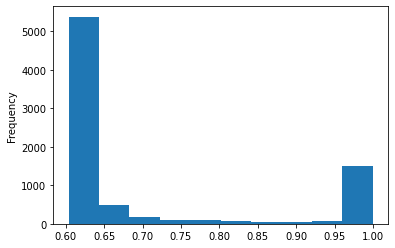

In [11]:
df_eval['pred'].plot.hist()

In [12]:
#0.718026